In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score,confusion_matrix,ConfusionMatrixDisplay,roc_curve, auc,roc_auc_score
from sklearn.linear_model import LogisticRegression
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
import pickle

## Load Data

In [2]:
# Load Classification Data
classification_data_df = pd.read_csv("./data/credit_classification_encode_fs_n_b89.csv")
classification_feature_list = classification_data_df.columns
# Features: fcredit_amount, checking_status, age, duration, purpose, credit_history, employment, savings_status, property_magnitude, residence_since, installment_commitment, personal_status, job, other_payment_plans, housing, existing_credits, class
print(f"Classification Features: \n f{', '.join(classification_feature_list)}")
print(len(classification_feature_list))
print()
#Our target will be 'Class', we will using 1 present good and 0 present bad
classification_data_type = classification_data_df.dtypes 
print(f"Classification Data Type: \n f{classification_data_type}")

Classification Features: 
 fcredit_amount, checking_status, age, duration, purpose, credit_history, employment, savings_status, property_magnitude, residence_since, installment_commitment, personal_status, job, other_payment_plans, housing, existing_credits, class
17

Classification Data Type: 
 fcredit_amount             float64
checking_status             int64
age                       float64
duration                  float64
purpose                     int64
credit_history              int64
employment                  int64
savings_status              int64
property_magnitude          int64
residence_since           float64
installment_commitment    float64
personal_status             int64
job                         int64
other_payment_plans         int64
housing                     int64
existing_credits          float64
class                       int64
dtype: object


The data we first feed has 17 columns and all numeric type:. 
Our target is ‘Class: good/bad’(discrete data)
I have encoded categorical type using label encoder and ordinal encoder, I have done normalization to prevent larger scaled features dominant the result, I also used feature selection to remove unimportant data (the threshold for this stage is small as I don’t want to filter out potential useful information), and I resampled the target class as the target class is unbalanced.


In [3]:
#Split Classification dataset into a training set and a test set
Classification_X = classification_data_df.drop('class',axis=1)
Classification_y = classification_data_df["class"]
Classification_X_train,Classification_X_test,Classification_y_train,Classification_y_test = train_test_split(Classification_X,Classification_y,test_size=0.2,random_state=0)

For this training and evaluation process, I have split the data into training_set (80%) and test_set(20%). As the model should work well not only within the current given data, but also robust to potential unknown data in real world. If we use all the current data we may have relatively good result, but without splitting and compare our model performance, the model may only perform well with given data and not robust to unknown real world result. This is the case where the model overfitting. And if the model even not work well with current given data, which means it is likely to underfit. In another word, the model did not find the real insights. We try to minimize the possibility to be overfit or underfit and we try to make the model more robust for future use. 
Using split data could help to justify the test design. It is more reliable as the data from the same dataset should follow the same distribution. (Just be mindful not overlap training and testing data in case of introducing overfitting)
Additionally, training set should larger than the test set. With sufficient data, the training model will be more representative and robust. The test set is just used to verify the training set build model performance.


In [4]:
#Choose an algorithm for Classification 
# Random Forrest
# Logistic regression
# Random Forrest

# This study is a supervised learning study, as all the data points are labelled, use the data points as inputs to build a model to get a desired output. And target class is discrete data, which is classification question. 
# Regression model used to predicts real numbers. Rather than saying whether the object is a mushroom or not, it mainly focuses on determining the probability of the object being/not being a mushroom. 


# Random Forrest and Gradient Boosting are Ensembles method. It is similar to the tree algorithm and could deal with both classification and regression problem. Ensembles combines a set of classifiers and combine their decisions in some way to get the result (voting, stacking and etc). It could handle errors or even correct errors
# But there is some constraints : each classier needs to be better than random (otherwise the combination may result worse); and each classifier needs to disagree with each other(they will infer each other)


## Train and Test a Model

In [5]:


# Random Forrest:
# Parameter set for RF model
rf_param_dict = {
    "n_estimators": range(10, 100), #It represents the number of trees in the random forest.
    "max_depth": [3, None], #It controls the maximum depth of the individual decision trees in the forest.
    "max_features": range(1, 11), #It determines the maximum number of features to consider for splitting at each node.
    "min_samples_split": range(2, 11), #It represents the minimum number of samples required to split an internal node.
    "min_samples_leaf": range(1, 11), #It represents the minimum number of samples required to be at a leaf node.
    "bootstrap": [True, False], #It determines whether bootstrap samples are used when building trees.
    "criterion": ["gini", "entropy"] #It represents the function to measure the quality of a split.
}
classification_rf_model = RandomForestClassifier()

# using random search to find out the best parameter setting for RF
random_search_rf = RandomizedSearchCV(classification_rf_model, param_distributions = rf_param_dict, n_iter = 20, cv = 5)
random_search_rf.fit(Classification_X_train, Classification_y_train)
print(f"Best parameters for RF model {random_search_rf.best_params_}")

classification_model_rf = random_search_rf.best_estimator_
# train the model using training set
classification_model_rf.fit(Classification_X_train, Classification_y_train)
# using model to do perdiction
classification_model_rf_predict = classification_model_rf.predict(Classification_X_test)
# calculate  accuracy of the model 
classification_model_rf_accuracy = accuracy_score(Classification_y_test, classification_model_rf_predict)

print(f"Accuracy: {classification_model_rf_accuracy * 100}%")
pickle.dump(classification_model_rf, open("credit_random_forrest.pkl", "wb"))

Best parameters for RF model {'n_estimators': 86, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_features': 6, 'max_depth': None, 'criterion': 'entropy', 'bootstrap': True}
Accuracy: 79.64285714285714%


In [6]:
#Logistic Regression
#Parameter set for LR model
lr_param_dist = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Inverse of regularization strength
    'penalty': ['l1', 'l2'],              # Regularization type
    'solver': ['liblinear', 'saga']       # Solver type
}
classification_lr_model = LogisticRegression()
lr_model_random_search = RandomizedSearchCV(classification_lr_model, param_distributions = lr_param_dist, n_iter = 20, cv = 5)
# train the model using training set
lr_model_random_search.fit(Classification_X_train, Classification_y_train)
print(f"Best parameters for LR model {lr_model_random_search.best_params_}")
classification_model_lr = lr_model_random_search.best_estimator_
# using model to do perdiction
classification_model_lr.fit(Classification_X_train, Classification_y_train)
# using model to do perdiction
classification_model_lr_predict = classification_model_lr.predict(Classification_X_test)
# calculate  accuracy of the model 

classification_model_lr_accuracy = accuracy_score(np.array(Classification_y_test), classification_model_lr_predict)

print(f"Accuracy: {classification_model_lr_accuracy * 100}%")

c:\Users\Kitty\Desktop\final\venv-msa\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Kitty\Desktop\final\venv-msa\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Kitty\Desktop\final\venv-msa\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Kitty\Desktop\final\venv-msa\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Kitty\Desktop\final\venv-msa\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Kitty\Desktop\final\venv-msa\Lib\sit

Best parameters for LR model {'solver': 'liblinear', 'penalty': 'l1', 'C': 1}
Accuracy: 72.85714285714285%


In [7]:
# Gradient boosting
#Parameter set for GB model
gb_param_dist = {
    'n_estimators': np.arange(10, 100),
    'learning_rate': [0.001, 0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5, None],
    'min_samples_split': np.arange(2, 11),
    'min_samples_leaf': np.arange(1, 11),
    'max_features': ['auto', 'sqrt', 'log2', None]
}


classification_gb_model = GradientBoostingClassifier()
gb_model_random_search = RandomizedSearchCV(classification_gb_model, param_distributions = gb_param_dist, n_iter = 20, cv = 5)
# train the model using training set
gb_model_random_search.fit(Classification_X_train, Classification_y_train)
print(f"Best parameters for GB model {gb_model_random_search.best_params_}")

classification_model_gb = gb_model_random_search.best_estimator_
# using model to do perdiction
classification_model_gb.fit(Classification_X_train, Classification_y_train)
# using model to do perdiction
classification_model_gb_predict = classification_model_gb.predict(Classification_X_test)
# calculate  accuracy of the model 
classification_model_gb_accuracy = accuracy_score(Classification_y_test, classification_model_gb_predict)
print(f"Accuracy: {classification_model_gb_accuracy * 100}%")

c:\Users\Kitty\Desktop\final\venv-msa\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
20 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Kitty\Desktop\final\venv-msa\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Kitty\Desktop\final\venv-msa\Lib\site-packages\sklearn\base.py", line 1144, in wrapper
    estimator._validate_params()
  File "c:\Users\Kitty\Desktop\final\venv-msa\Lib\site-packages\sklearn\base.py", line 637, in _validate_params
    validate_parameter_constraints

Best parameters for GB model {'n_estimators': 69, 'min_samples_split': 8, 'min_samples_leaf': 9, 'max_features': 'log2', 'max_depth': None, 'learning_rate': 0.1}
Accuracy: 83.21428571428572%


# Evaluate the model



Recall: 0.8085106382978723
Precision: 0.7916666666666666
F-measure: 0.7999999999999999
Confusion Matrix for Random Forrest:


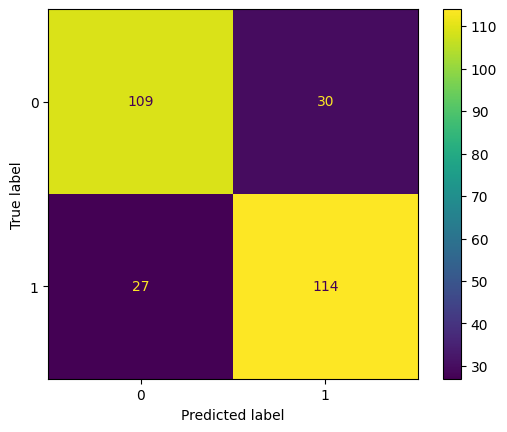

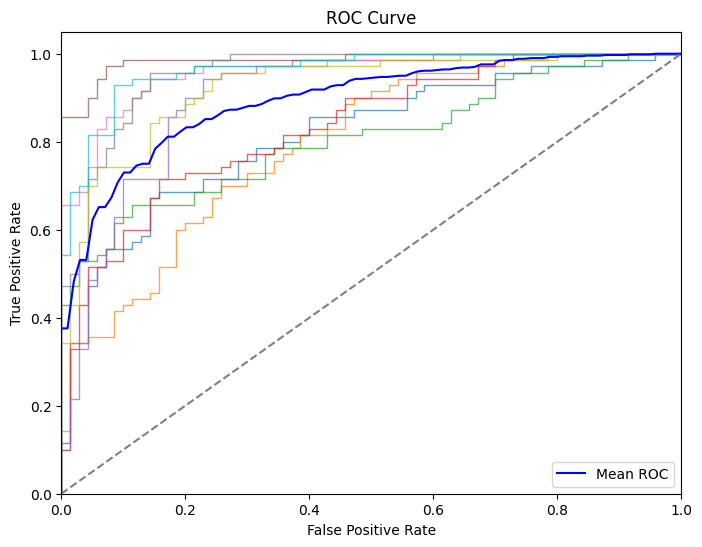

Fold 1 AUC: 0.8161
Fold 2 AUC: 0.7973
Fold 3 AUC: 0.8076
Fold 4 AUC: 0.8341
Fold 5 AUC: 0.9043
Fold 6 AUC: 0.9857
Fold 7 AUC: 0.9578
Fold 8 AUC: 0.9561
Fold 9 AUC: 0.9241
Fold 10 AUC: 0.9633
Mean AUC: 0.8946


In [8]:
# Confusion Matrix for Random Forrest
rf_confusion_matrix = confusion_matrix(Classification_y_test, classification_model_rf_predict)
tn, fp, fn, tp = rf_confusion_matrix.ravel()
recall = tp /(tp + fn)
precision = tp / (tp + fp)
f_measure = ((2* recall)*precision)/(recall + precision)
print(f"Recall: {recall}")
print(f"Precision: {precision}")
print(f"F-measure: {f_measure}")
print("Confusion Matrix for Random Forrest:")

rf_matrix_display = ConfusionMatrixDisplay(rf_confusion_matrix).plot()


#ROC Cure and AUC and 10 cross validation
cv = StratifiedKFold(n_splits=10)

roc_curves = []
auc_scores = []


for train_idx, test_idx in cv.split(Classification_X,Classification_y):
    X_train, X_test = Classification_X.iloc[train_idx], Classification_X.iloc[test_idx]
    y_train, y_test = Classification_y.iloc[train_idx], Classification_y.iloc[test_idx]
    classification_model_rf.fit(X_train, y_train)
    y_score = classification_model_rf.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    roc_curves.append((fpr, tpr, roc_auc))
    auc_scores.append(roc_auc)

plt.figure(figsize=(8, 6))
for fpr, tpr, roc_auc in roc_curves:
    plt.plot(fpr, tpr, lw=1, alpha=0.7)
mean_fpr = np.linspace(0, 1, 100)
mean_tpr = np.mean([np.interp(mean_fpr, fpr, tpr) for fpr, tpr, _ in roc_curves], axis=0)
plt.plot(mean_fpr, mean_tpr, color='b', label='Mean ROC')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()
for fold, auc_score in enumerate(auc_scores, start=1):
    print(f"Fold {fold} AUC: {auc_score:.4f}")

mean_auc = np.mean(auc_scores)
print(f"Mean AUC: {mean_auc:.4f}")

Recall: 0.7588652482269503
Precision: 0.7181208053691275
F-measure: 0.7379310344827585
Confusion Matrix for Logistic Regression:


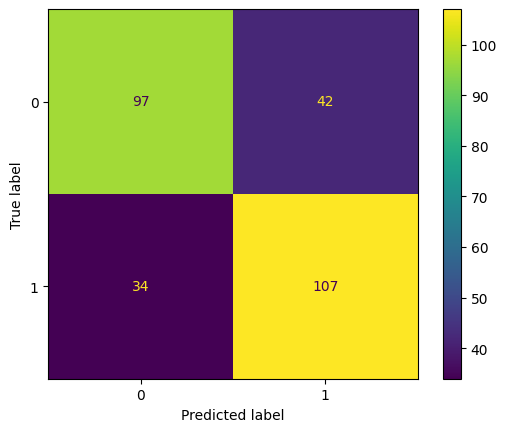

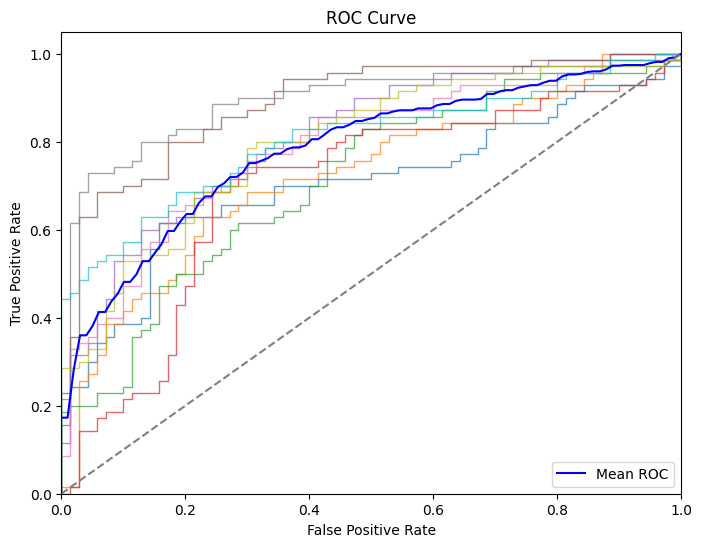

Fold 1 AUC: 0.7049
Fold 2 AUC: 0.7233
Fold 3 AUC: 0.7143
Fold 4 AUC: 0.6967
Fold 5 AUC: 0.8120
Fold 6 AUC: 0.8898
Fold 7 AUC: 0.7878
Fold 8 AUC: 0.8955
Fold 9 AUC: 0.7969
Fold 10 AUC: 0.8057
Mean AUC: 0.7827


In [9]:
# Confusion Matrix for Logistic Regression
lr_confusion_matrix = confusion_matrix(Classification_y_test, classification_model_lr_predict)
tn, fp, fn, tp = lr_confusion_matrix.ravel()
recall = tp /(tp + fn)
precision = tp / (tp + fp)
f_measure = ((2* recall)*precision)/(recall + precision)
print(f"Recall: {recall}")
print(f"Precision: {precision}")
print(f"F-measure: {f_measure}")
print("Confusion Matrix for Logistic Regression:")



ConfusionMatrixDisplay(lr_confusion_matrix).plot()

#ROC Cure and AUC and 10 cross validation
cv = StratifiedKFold(n_splits=10)

roc_curves = []
auc_scores = []


for train_idx, test_idx in cv.split(Classification_X,Classification_y):
    X_train, X_test = Classification_X.iloc[train_idx], Classification_X.iloc[test_idx]
    y_train, y_test = Classification_y.iloc[train_idx], Classification_y.iloc[test_idx]
    classification_model_lr.fit(X_train, y_train)
    y_score = classification_model_lr.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    roc_curves.append((fpr, tpr, roc_auc))
    auc_scores.append(roc_auc)

plt.figure(figsize=(8, 6))
for fpr, tpr, roc_auc in roc_curves:
    plt.plot(fpr, tpr, lw=1, alpha=0.7)
mean_fpr = np.linspace(0, 1, 100)
mean_tpr = np.mean([np.interp(mean_fpr, fpr, tpr) for fpr, tpr, _ in roc_curves], axis=0)
plt.plot(mean_fpr, mean_tpr, color='b', label='Mean ROC')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()
for fold, auc_score in enumerate(auc_scores, start=1):
    print(f"Fold {fold} AUC: {auc_score:.4f}")
mean_auc = np.mean(auc_scores)
print(f"Mean AUC: {mean_auc:.4f}")

Recall: 0.8581560283687943
Precision: 0.8175675675675675
F-measure: 0.8373702422145328
Confusion Matrix for Gradient Boosting:


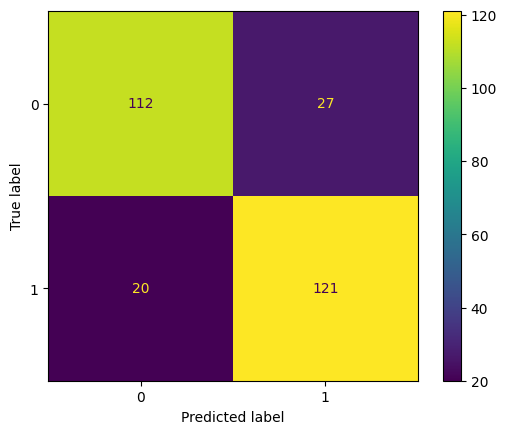

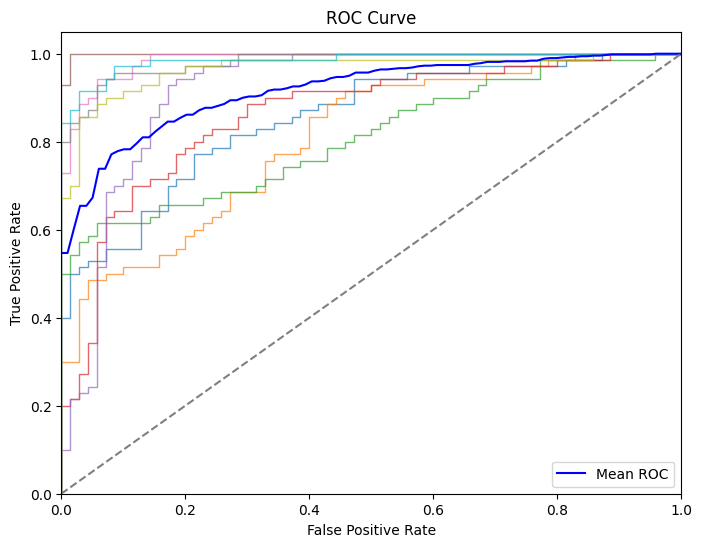

Fold 1 AUC: 0.8541
Fold 2 AUC: 0.8069
Fold 3 AUC: 0.8104
Fold 4 AUC: 0.8614
Fold 5 AUC: 0.9180
Fold 6 AUC: 0.9990
Fold 7 AUC: 0.9867
Fold 8 AUC: 0.9820
Fold 9 AUC: 0.9659
Fold 10 AUC: 0.9855
Mean AUC: 0.9170


In [10]:
# Confusion Matrix for Gradient Boosting
gb_confusion_matrix = confusion_matrix(Classification_y_test, classification_model_gb_predict)
tn, fp, fn, tp = gb_confusion_matrix.ravel()
recall = tp /(tp + fn)
precision = tp / (tp + fp)
f_measure = ((2* recall)*precision)/(recall + precision)
print(f"Recall: {recall}")
print(f"Precision: {precision}")
print(f"F-measure: {f_measure}")
print("Confusion Matrix for Gradient Boosting:")
ConfusionMatrixDisplay(gb_confusion_matrix).plot()

#ROC Cure and AUC and 10 cross validation
cv = StratifiedKFold(n_splits=10)

roc_curves = []
auc_scores = []


for train_idx, test_idx in cv.split(Classification_X,Classification_y):
    X_train, X_test = Classification_X.iloc[train_idx], Classification_X.iloc[test_idx]
    y_train, y_test = Classification_y.iloc[train_idx], Classification_y.iloc[test_idx]
    classification_model_gb.fit(X_train, y_train)
    y_score = classification_model_gb.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    roc_curves.append((fpr, tpr, roc_auc))
    auc_scores.append(roc_auc)

plt.figure(figsize=(8, 6))
for fpr, tpr, roc_auc in roc_curves:
    plt.plot(fpr, tpr, lw=1, alpha=0.7)
mean_fpr = np.linspace(0, 1, 100)
mean_tpr = np.mean([np.interp(mean_fpr, fpr, tpr) for fpr, tpr, _ in roc_curves], axis=0)
plt.plot(mean_fpr, mean_tpr, color='b', label='Mean ROC')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()
for fold, auc_score in enumerate(auc_scores, start=1):
    print(f"Fold {fold} AUC: {auc_score:.4f}")
mean_auc = np.mean(auc_scores)
print(f"Mean AUC: {mean_auc:.4f}")


### Summary

steps: 
    I have loaded the data and then split the data as training set(80%) for training the model and test set(20%) for testing the training model performance.

    Then I used RandomizedSearchCV to figure the best parameter for different models. 

    I have used three model: logistic regressionn (regression algorithm), gradient boosting and random forrest (the last two are ensembles)

    I have print out the recall, percision, and F-measure confutsion matrix, ROC curve and AUC result.

    I also done 10-cross validation to make the result more reliable. 

Result:
    ROC is the probability curve and AUC represents the degree or measure of separability. Higher the AUCm the better the model predict class good as good and class bad as bad. 

    From the ROC curve we can see that the ensemble algorithm performs relatively better performance than regression algorithm, and graient boosting done the best among others. 

    For the mean value of AUC we could see that ensemnle algorithm (gradient boosting and random forrest) have around 90% chance that ditinguish between postive and negative class. Well the regression algorithm only performs 77% chance to get them distinguished.
    
    The reason may due to algorithm differecen as regression algorithm could handle errors but the result may skew. While ensembels algorithm is more robust in this case.

Interesting finding:

    For imbalanced classification problem target, we should do resampling, otherwise, even random guess can get a relatively good interpretation. And other parameter tuning does not enhance much of the prediction performance. 
    

    

